# LangChain

This notebook implements a prompt chain with LangChain framework, fine-tuning DeepSeek to conduct sentiment analysis on our dataset.

## 1. Import Libraries

In [ ]:
#!pip install -U langchain langchain-community

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from langchain.prompts import PromptTemplate
from langchain_community.llms import HuggingFacePipeline
from langchain.chains import LLMChain
import json
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoModelForSeq2SeqLM
import torch
import accelerate

#!wget https://raw.githubusercontent.com/CKZ1107/COMP6713-NLP/refs/heads/main/dataset.csv
#df = pd.read_csv('dataset.csv')

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## 2. Prepare Dataset

In [2]:
from helpers.setup import *
from helpers.model import *
from helpers.evaluation import *
from helpers.dataset import get_split_datasets

# Model hyperparameters
max_chunk_length = 256
max_chunks = 8
batch_size = 4
num_epochs = 45
learning_rate = 2e-5
aggregation_method = 'attention'
early_stopping_patience = 6
use_wordnet = True
focal_gamma = 2.0

# dataset and dataloaders
df = pd.read_csv(dataset_path)
train_datasets, val_datasets, test_datasets = get_split_datasets(
    df, labels=label_list, use_wordnet=use_wordnet, max_chunk_length=max_chunk_length, max_chunks=max_chunks
)
train_loader, train_df = train_datasets
val_loader, val_df = val_datasets
test_loader, test_df = test_datasets
num_stocks = len(df[stock].unique())
'''
df = pd.read_csv('dataset.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Sort by time
df = df.sort_values("trading_day")

# Choose cutoff time to simulate "future" prediction
unique_times = df["trading_day"].unique()
cutoff_time = unique_times[int(len(unique_times) * 0.8)]

# Inference set only
test_df = df[df["trading_day"] > cutoff_time]

print(test_df.columns)
print(test_df[["trading_day", "stock", "post", "label"]].isnull().sum())
test_df = test_df[["trading_day", "stock", "post", "label"]].dropna().copy()

print(test_df.head())
'''

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to /Users/carey/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /Users/carey/nltk_data...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/carey/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/carey/nltk_data...


[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package omw-1.4 to /Users/carey/nltk_data...


NLTK resource download complete
MPS (Apple Silicon) device detected!
Train set: 2979 examples
Validation set: 590 examples
Test set: 615 examples

Testing WordNet enhancement...
Original: I bought my first $AAPL stock in 2010. Since then it has seen a 1,372.29% increase. Tell me again. W...
Enhanced: I bought my first $AAPL stock in 2010 . Since then it has have seen a 1,372.29% increase addition . ...

Original: Why can XPeng P5 deliver outstanding performance in extreme conditions? CEO He Xiaopeng explains the...
Enhanced: Why can tin XPeng P5 deliver outstanding performance in extreme conditions ? CEO He Xiaopeng explain...

Original: @TSM_Myth You dismantled me mentally and emotionally today [SEP] @TSM_Myth You did great! Dont be so...
Enhanced: @TSM_Myth You dismantled level me mentally and emotionally today [SEP] @TSM_Myth You did make great ...



'\ndf = pd.read_csv(\'dataset.csv\')\n\n# Display basic information\nprint(f"Dataset shape: {df.shape}")\nprint("\nFirst few rows:")\ndisplay(df.head())\n\n# Check for missing values\nprint("\nMissing values:")\nprint(df.isnull().sum())\n\n# Sort by time\ndf = df.sort_values("trading_day")\n\n# Choose cutoff time to simulate "future" prediction\nunique_times = df["trading_day"].unique()\ncutoff_time = unique_times[int(len(unique_times) * 0.8)]\n\n# Inference set only\ntest_df = df[df["trading_day"] > cutoff_time]\n\nprint(test_df.columns)\nprint(test_df[["trading_day", "stock", "post", "label"]].isnull().sum())\ntest_df = test_df[["trading_day", "stock", "post", "label"]].dropna().copy()\n\nprint(test_df.head())\n'

In [7]:
!rm -rf ~/.cache/huggingface

## 3. Model setup

In [4]:
model_name = "deepseek-ai/deepseek-coder-1.3b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, torch_dtype=torch.bfloat16).cuda()

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    device=0 if torch.cuda.is_available() else -1
)
llm = HuggingFacePipeline(pipeline=pipe)

'''
# Use smaller model for testing purpose
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Create pipeline
pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256,
)

# Wrap in LangChain
llm = HuggingFacePipeline(pipeline=pipe)
'''


model.safetensors:  18%|#7        | 482M/2.69G [00:00<?, ?B/s]

KeyboardInterrupt: 

## 4. Propmt Template with 3D Inputs (time, stock, post)

In [11]:
template = """
You are a financial expert who's been doing sentiment analysis on social media for years.
Given the following social media post with timestamp and stock code:

Time: {time}
Stock: {stock}
Post: "{post}"

Classify the sentiment of this post toward the stock price.
Respond in JSON format with three fields:
- sentiment: one of [positive, negative]
- prediction: one of [increase, decrease]
- justification: your reasoning, 1-2 sentences long

Your answer:
"""

prompt = PromptTemplate(
    input_variables=["time", "stock", "post"],
    template=template,
)

chain = LLMChain(llm=llm, prompt=prompt)

<ipython-input-11-1ecedfe51c46>:23: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=llm, prompt=prompt)


In [12]:
def classify_with_voting(row, n_votes=3):
    predictions = []

    for i in range(n_votes):
        try:
            response = chain.invoke({
                "time": str(row["trading_day"]),
                "stock": row["stock"],
                "post": row["post"][:450]
            })

            if "text" in response:
                predictions.append(response["text"].lower())
            else:
                print(f"❌ Run {i+1}: Missing 'prediction' key →", response)

        except Exception as e:
            print(f"❌ Run {i+1} failed for row:\n{row}")
            print("❌ Error:", e)

    if predictions:
        # Count and return the majority prediction
        prediction_counts = Counter(predictions)
        majority = prediction_counts.most_common(1)[0][0]
        return majority
    else:
        return "unknown"

In [ ]:
test_df["majority_sentiment"] = test_df.apply(classify_with_voting, axis=1)

def map_prediction_to_label(prediction_str):
    pred = prediction_str.strip().lower()
    if "positive" in pred:
        return 1
    elif "negative" in pred:
        return -1
    else:
        return None

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Accuracy: 0.4641
F1 Score: 0.4409


<Figure size 600x600 with 0 Axes>

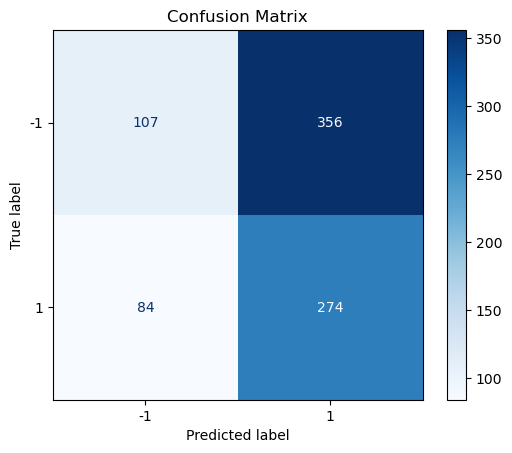

In [ ]:
y_true = test_df["label"]
y_pred = test_df["majority_sentiment"].apply(map_prediction_to_label)

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="macro")  # or "weighted" if class imbalance

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

labels = [-1, 1]

cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()